In [39]:
import lightkurve as lk
%matplotlib inline
# Search for Kepler observations of Kepler-69
search_result = lk.search_lightcurve('Kepler-11', author='Kepler', cadence='long')
# Download all available Kepler light curves
lc_collection = search_result.download_all()
lc_collection.plot(); 

In [40]:
lc = lc_collection.stitch().flatten(window_length=901).remove_outliers()
lc.plot()

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

In [41]:
import numpy as np
# Create array of periods to search
period = np.linspace(1, 80, 10000)
# Create a BLSPeriodogram
bls = lc.to_periodogram(method='bls', period=period, frequency_factor=500);
bls.plot();

In [42]:
planet_b_period = bls.period_at_max_power
planet_b_t0 = bls.transit_time_at_max_power
planet_b_dur = bls.duration_at_max_power
ax = lc.fold(period=planet_b_period, epoch_time=planet_b_t0).scatter()
bls.frequency_at_max_power
ax.set_xlim(-5, 5);

In [43]:
ax = lc.fold(period=planet_b_period, epoch_time=planet_b_t0).scatter()
ax.set_xlim(-5, 5);

Running burn-in...


  0%|          | 0/500 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 500/500 [00:00<00:00, 1690.38it/s]


Running production...


100%|██████████| 10000/10000 [01:00<00:00, 164.93it/s]


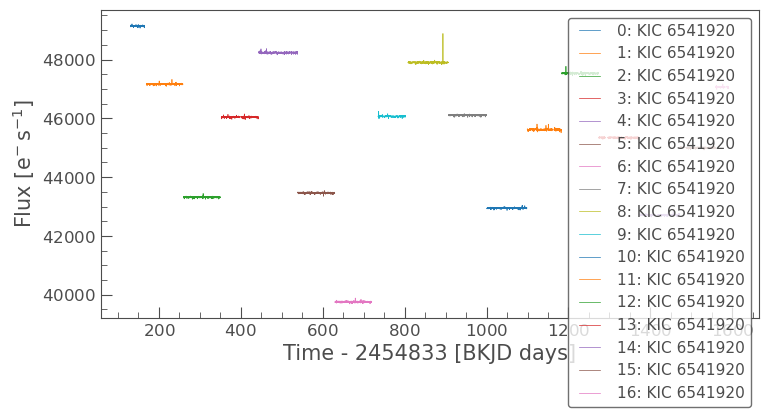

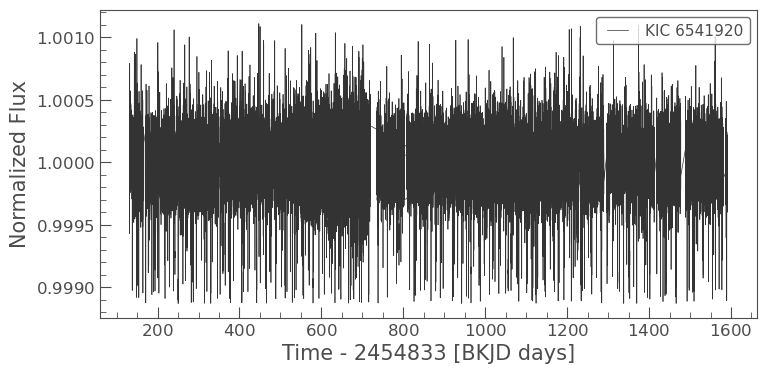

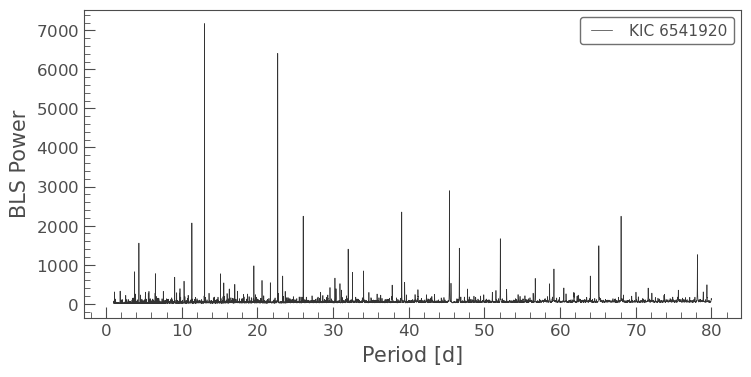

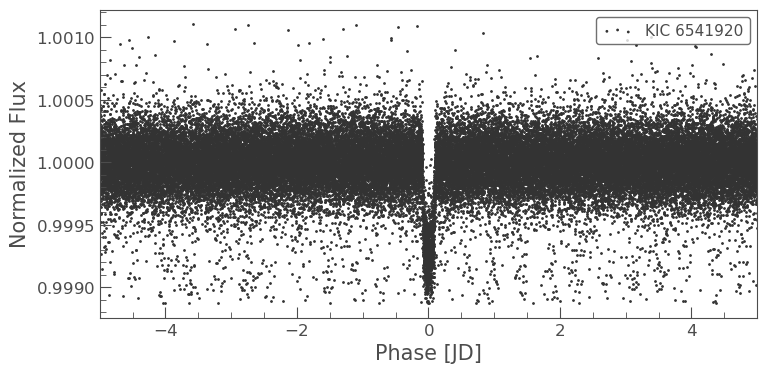

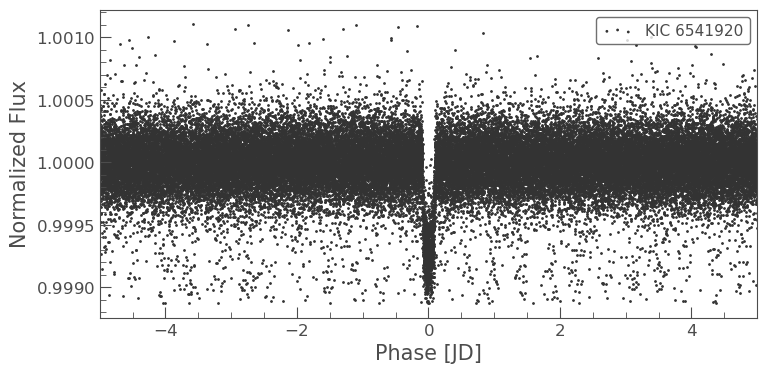

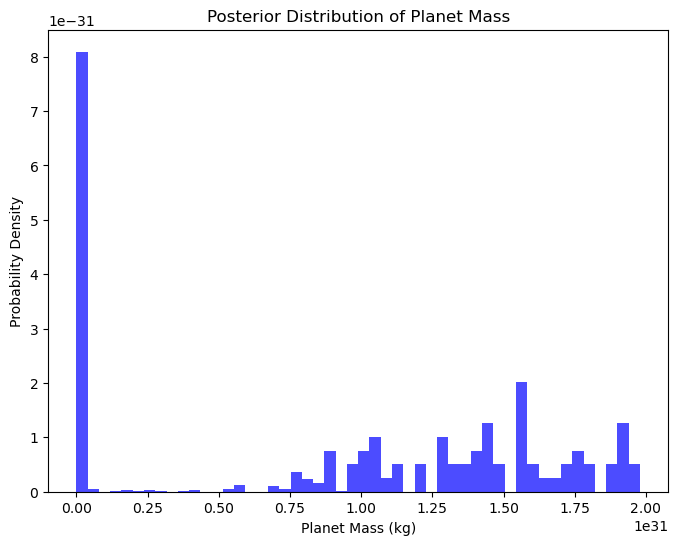

Estimated planet mass: 1.09e+31 kg ± 7.16e+30 kg


In [44]:
import numpy as np
import matplotlib.pyplot as plt
import emcee

# Assuming you have these imported or defined elsewhere:
# `time_series` -> Time series data: a tuple (time, flux, flux_err)




# Example time-series data (replace with your actual data)
time = bls.time.value   # Time array
flux = bls.flux.value 
flux_err = lc["flux_err"].value

# Known parameters
period = bls.period_at_max_power.value  # Period of the planet in days
duration = bls.duration_at_max_power.value  # Duration of the transit in days
depth = bls.depth_at_max_power.value# Depth of the transit


# Physical constants
G = 6.67430e-11  # Gravitational constant, m^3 kg^-1 s^-2
M_sun = 1.989e30  # Solar mass, kg
R_sun = 6.957e8  # Solar radius, m

# Stellar parameters (replace with actual values if known)
M_star = 1.0 * M_sun  # Mass of the star in kg
R_star = 1.0 * R_sun  # Radius of the star in meters


# Transit model
def transit_model(time, period, duration, depth):
    """
    Simple box transit model: assumes flat-bottom transit.
    """
    phase = (time % period) / period
    in_transit = (phase < (duration / period) / 2) | (phase > (1 - (duration / period) / 2))
    model_flux = np.ones_like(time)
    model_flux[in_transit] -= depth
    return model_flux


# Likelihood function
def log_likelihood(params, time, flux, flux_err):
    Mp = params[0]  # Planet mass
    # Derived semi-major axis using Kepler's third law
    a = ((G * M_star * (period * 86400) ** 2) / (4 * np.pi ** 2)) ** (1 / 3)
    # Relation between mass and radius (optional improvement: use empirical MR relation)
    R_p = (Mp / M_sun) ** (1 / 3) * R_sun

    model_flux = transit_model(time, period, duration, depth)
    residuals = flux - model_flux
    return -0.5 * np.sum((residuals / flux_err) ** 2)


# Prior function
def log_prior(params):
    Mp = params[0]  # Planet mass
    if 0.00001 * M_sun < Mp < 0.01 * M_sun:  # Reasonable bounds for planet mass
        return 0.0
    return -np.inf


# Posterior function
def log_posterior(params, time, flux, flux_err):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, time, flux, flux_err)


# Initial guesses
initial_mass_guess = 1/33333333 * M_sun
nwalkers = 100
ndim = 1

# Spread initial positions randomly within a range (e.g., prior bounds)
initial_pos = np.random.uniform(
    low=0.1 * M_sun, high=10.0 * M_sun, size=(nwalkers, ndim)
)

# Set up MCMC sampler
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, args=(time, flux, flux_err)
)

# Burn-in phase
print("Running burn-in...")
n_burn = 500
pos, prob, state = sampler.run_mcmc(initial_pos, n_burn, progress=True)

# Reset sampler and run production
print("Running production...")
sampler.reset()
n_steps = 10000
sampler.run_mcmc(pos, n_steps, progress=True)

# Analyze results
samples = sampler.get_chain(flat=True)
mass_samples = samples[:, 0]

# Plot the posterior distribution
plt.figure(figsize=(8, 6))
plt.hist(mass_samples, bins=50, density=True, alpha=0.7, color="blue")
plt.xlabel("Planet Mass (kg)")
plt.ylabel("Probability Density")
plt.title("Posterior Distribution of Planet Mass")
plt.show()

# Print summary statistics
mass_median = np.median(mass_samples)
mass_std = np.std(mass_samples)
print(f"Estimated planet mass: {mass_median:.2e} kg ± {mass_std:.2e} kg")

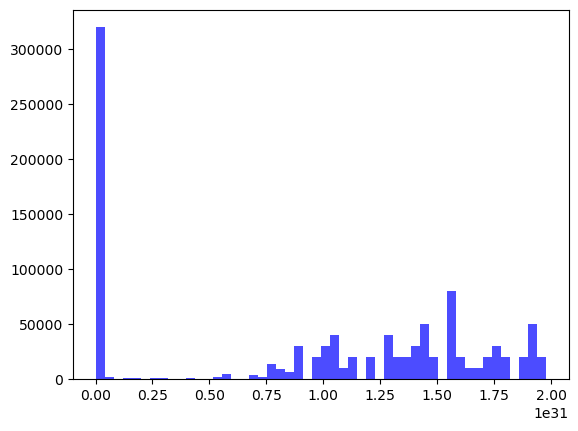

In [47]:
plt.hist(mass_samples, bins=50, alpha=0.7, color="blue")
plt.show()

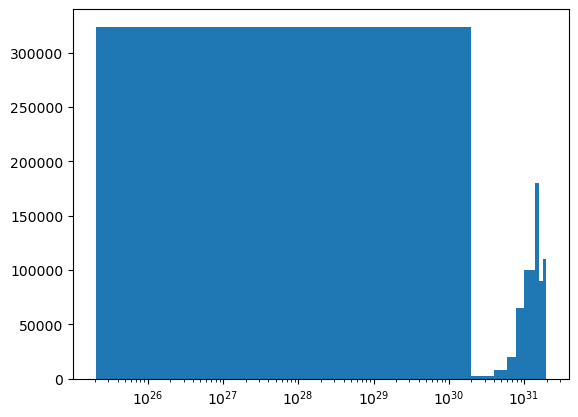

In [48]:

plt.hist(mass_samples)
plt.semilogx()
plt.show()

In [50]:
np.min(mass_samples)

2.02943465084069e+25